## Train parkinson classifier notebook

Install the libraries

In [21]:
!pip3 install --quiet numpy
!pip3 install --quiet pandas
!pip3 install --quiet scipy
!pip3 install --quiet matplotlib
!pip3 install --quiet seaborn
!pip3 install --quiet sklearn
!pip3 install --quiet imblearn
!pip3 install --quiet xgboost

Intialize google drive with data (create the directories "Colab Notebooks/Parkinson_Classifier" on your google drive)

---



In [37]:
import os

from google.colab import drive

# Mount the google drive
drive.mount("/content/gdrive", force_remount=True)

# Prepare the paths
main_folder = os.path.join("/content", "gdrive", "My Drive", "Colab Notebooks", "Parkinson_Classifier")

# Folders will be named like this, to give ability to try more models
model_name = "2022-03-30"
model_dir = os.path.join(main_folder, model_name)

if not os.path.exists(model_dir):
  os.mkdir(model_dir)

Mounted at /content/gdrive


Set up the visual styles for plots

In [ ]:
import seaborn as sns
from matplotlib import pyplot as plt

def set_visual_styles():
    # Matplotlib settings
    plt.style.use("classic")
    # Seaborn settings
    sns.set()
    sns.set(font_scale=1.0)
    sns.set_style({"font.family": "serif", "font.serif": ["Times New Roman"]}) # Set according to your latex/word
    # Show seaborn settings
    sns.axes_style()

## Dataset preparation

Load dataset

In [6]:
import pandas as pd

# Load dataset
df = pd.read_excel(os.path.join(main_folder, "dataset_hilev_FNUSA.xlsx"), index_col=0)

# Look at those dataset
df.head(10)

Subject       Date  Probable Parkinson Disease  \
0  pre-LBD-1 2020-06-24                        True   
1  pre-LBD-1 2020-06-25                        True   
2  pre-LBD-1 2020-06-26                        True   
3  pre-LBD-1 2020-06-27                        True   
4  pre-LBD-1 2020-06-28                        True   
5  pre-LBD-1 2020-06-29                        True   
6  pre-LBD-1 2020-06-30                        True   
7  pre-LBD-2 2020-06-10                        True   
8  pre-LBD-2 2020-06-11                        True   
9  pre-LBD-2 2020-06-12                        True   

   Probable Mild Cognitive Impairment  Hemicrania Continua  Sleep Apnea  \
0                               False                False        False   
1                               False                False        False   
2                               False                False        False   
3                               False                False        False   
4                               False                False        False   
5                               False                False        False   
6                               False                False        False   
7                                True                False        False   
8                                True                False        False   
9                                True                False        False   

   Time in bed (A)  Sleep onset latency (A)  Sleep onset latency - norm (A)  \
0            26100                      286                               1   
1            27900                      316                               1   
2            26700                      166                               1   
3            13200                      376                               1   
4            24720                      496                               1   
5            22800                      196                               1   
6            23400                       46                               1   
7            33300                     1194                               1   
8            33000                       24                               1   
9            36600                       84                               1   

   Wake after sleep onset (A)  ...  Wake after sleep onset (D)  \
0                        9210  ...                         420   
1                       13260  ...                        3000   
2                        6930  ...                         360   
3                        2490  ...                        1200   
4                       11910  ...                         900   
5                        9720  ...                         120   
6                        2370  ...                         900   
7                       20160  ...                        1200   
8                       21540  ...                        1200   
9                       18270  ...                       44700   

   Wake after sleep onset - norm (D)  Wake after sleep offset (D)  \
0                                  0                         3600   
1                                  0                         6300   
2                                  0                         4200   
3                                  0                         2700   
4                                  0                          600   
5                                  0                          600   
6                                  0                         1200   
7                                  0                          600   
8                                  0                          600   
9                                  0                          600   

   Total sleep time (D)  Wake bouts (D)  Awakening > 5 minutes (D)  \
0                 21180               2                          1   
1                 17400               2                          2   
2     

Prepare data

In [7]:
# Names of the features
names = ['Time in bed (A)',
         'Sleep onset latency (A)',
         'Sleep onset latency - norm (A)',
         'Wake after sleep onset (A)',
         'Wake after sleep onset - norm (A)',
         'Wake after sleep offset (A)',
         'Total sleep time (A)',
         'Wake bouts (A)',
         'Awakening > 5 minutes (A)',
         'Awakening > 5 minutes - norm (A)',
         'Sleep efficiency (A)',
         'Sleep efficiency - norm (A)',
         'Sleep fragmentation (A)',

         'Time in bed (D)',
         'Sleep onset latency (D)',
         'Sleep onset latency - norm (D)',
         'Wake after sleep onset (D)',
         'Wake after sleep onset - norm (D)',
         'Wake after sleep offset (D)',
         'Total sleep time (D)',
         'Wake bouts (D)',
         'Awakening > 5 minutes (D)',
         'Awakening > 5 minutes - norm (D)',
         'Sleep efficiency (D)',
         'Sleep efficiency - norm (D)',
         'Sleep fragmentation (D)',
         ]

# Features
x = df[names].values
# Scale -> Can change the name of the disease to change the experiment
y = (df['Probable Parkinson Disease']).values
y = y.reshape((len(y),))

Discover information about the dataset

In [9]:
def log_data_info(y_in):
    y_tmp = y_in.ravel()
    print(f'Data len: {len(y_tmp)}')
    parkinson = [e for e in y_tmp if e]
    healthy = [e for e in y_tmp if not e]
    print('Percentage of parkinson/healthy people:')
    print(f'Parkinson: {len(parkinson)} entries, {(len(parkinson) / len(y_tmp)) * 100:.2f}%')
    print(f'Healthy: {len(healthy)} entries, {(len(healthy) / len(y_tmp)) * 100:.2f}%')

log_data_info(y)

Data len: 654
Percentage of parkinson/healthy people:
Parkinson: 160 entries, 24.46%
Healthy: 494 entries, 75.54%


Split data into train & test data

In [10]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.4, random_state=13)
y_train = y_train.reshape((len(y_train),))

Discover information about train and test data

In [11]:
print("--- Train data ---")
log_data_info(y_train)

print("--- Test data ---")
log_data_info(y_test)

--- Train data ---
Data len: 392
Percentage of parkinson/healthy people:
Parkinson: 100 entries, 25.51%
Healthy: 292 entries, 74.49%
--- Test data ---
Data len: 262
Percentage of parkinson/healthy people:
Parkinson: 60 entries, 22.90%
Healthy: 202 entries, 77.10%


Get rid of NaN (if any)

In [12]:
from sklearn.impute import KNNImputer

# Add NaN according to K-nearest neighbours
imputer = KNNImputer(n_neighbors=4, weights="uniform")
x_train = imputer.fit_transform(x_train)

Add synthetic values to balance dataset via SMOTE or ADASYN

In [16]:
from imblearn.over_sampling import SMOTE, ADASYN

# You can use SMOTE
# sm = SMOTE(random_state=27)
# x_train, y_train = sm.fit_resample(x_train, y_train)

# Or you can use ADASYN
ad = ADASYN(random_state=27)
x_train, y_train = ad.fit_resample(x_train, y_train)


Discover information about balanced dataset

In [17]:
log_data_info(y_train)

Data len: 584
Percentage of parkinson/healthy people:
Parkinson: 292 entries, 50.00%
Healthy: 292 entries, 50.00%


## Search best hyper parameters for model

Define the classifier settings

In [27]:
model_params = {
    # General parameters
    "booster": "gbtree",
    "verbosity": 1,
    "n_jobs": -1,

    # Learning task parameters
    "objective": "binary:logistic",  # https://xgboost.readthedocs.io/en/latest/parameter.html
    "eval_metric": ["rmse", "error", "logloss", "auc"],
    "seed": 42,
    # Tree Booster parameters
    "n_estimators": 1000,
    "learning_rate": 0.20,
    "gamma": 1.0,
    "max_depth": 6,
    "subsample": 1.0,
    "colsample_bylevel": 1,
    "colsample_bytree": 1.0,
    "min_child_weight": 5,

    # # GPU setting
    "gpu_id": 0,
    "tree_method": "hist",
}

Create classifier XGBoost

In [28]:
from xgboost.sklearn import XGBClassifier

model = XGBClassifier(**model_params)

Define settings for hyper parameters search

In [29]:
param_grid = {
    "learning_rate": [0.001, 0.01, 0.1, 0.2, 0.3],
    "gamma": [0, 0.10, 0.15, 0.25, 0.5],
    "max_depth": [6, 8, 10, 12, 15],
    "min_child_weight": [0.5, 1.0, 3.0, 5.0, 7.0, 10.0],
    "colsample_bylevel": [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    "colsample_bytree": [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    "scale_pos_weight": [1, 3, 5, 6, 7, 9]  # https://machinelearningmastery.com/xgboost-for-imbalanced-classification/
}

search_settings = {
    "param_distributions": param_grid,
    "scoring": "f1_micro",  # https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
    "n_jobs": -1,
    "n_iter": 100,
    "verbose": 1
}

Search best hyper params (this step takes longer, like 15 minutes, you can load the model instead if it exists)

In [30]:
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV

# Get the cross-validation indices
kfolds = StratifiedKFold(n_splits=10, shuffle=True)

# Employ the hyper-parameter tuning
y = y.astype(bool)
random_search = RandomizedSearchCV(model, cv=kfolds.split(x, y), **search_settings)
random_search.fit(x, y)

print(f'Estimator: score = {random_search.best_score_:.4f} | model = {random_search.best_estimator_}')
params = random_search.best_params_

Fitting 10 folds for each of 100 candidates, totalling 1000 fits
Estimator: score = 0.7997 | model = XGBClassifier(colsample_bylevel=0.7, colsample_bytree=0.6,
              eval_metric=['rmse', 'error', 'logloss', 'auc'], gpu_id=0,
              learning_rate=0.01, max_depth=15, min_child_weight=1.0,
              n_estimators=1000, n_jobs=-1, seed=42, subsample=1.0,
              tree_method='hist')


## Rather save the hyperparams on google disk (optional)

Define save & load methods

In [31]:
import pickle


def save_obj(obj, path):
    with open(path, 'wb+') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)


def load_obj(path):
    with open(path, 'rb') as f:
        return pickle.load(f)



Define hyper params path

In [36]:
# prepare directory
params_dir = os.path.join(model_dir, "hyperparams")
if not os.path.exists(params_dir):
  os.mkdir(params_dir)

# define path
params_path = os.path.join(params_dir, "hyperparams.pkl")

Save hyper parameters

In [38]:
save_obj(params, params_path)

Load hyper parameters (if it is desired instead of hyper parameters tunning)

In [39]:
params = load_obj(params_path)

## Cross validation

Define cross validation scoring

In [42]:
from sklearn.metrics import recall_score, confusion_matrix, make_scorer, accuracy_score, matthews_corrcoef, f1_score


def sensitivity_score(y_true, y_pred):
    return recall_score(y_true, y_pred)


def specificity_score(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return tn / (tn + fp)


# Prepare the scoring
scoring = {
    "acc": make_scorer(accuracy_score),
    "sen": make_scorer(sensitivity_score),
    "spe": make_scorer(specificity_score),
    "f1": make_scorer(f1_score),
    "mcc": make_scorer(matthews_corrcoef),
}

Perform cross validation

In [43]:
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import RepeatedStratifiedKFold, cross_validate

# Prepare data
y_train = y_train.ravel()

# Create new model with best hyper parameters
model = XGBClassifier(**params) # use previously found best hyper parameters

# Prepare the cross-validation scheme
kfolds = RepeatedStratifiedKFold(n_splits=10, n_repeats=20)

# Cross validation itself
cv_results = cross_validate(model, x_train, y_train, scoring=scoring, cv=kfolds)

Print results of cross validation

In [48]:
import numpy as np

def results_to_print(cv_results):
    # Compute the mean and std of the metrics
    cls_report = {
        "acc_avg": round(float(np.mean(cv_results["test_acc"])), 4),
        "acc_std": round(float(np.std(cv_results["test_acc"])), 4),
        "sen_avg": round(float(np.mean(cv_results["test_sen"])), 4),
        "sen_std": round(float(np.std(cv_results["test_sen"])), 4),
        "spe_avg": round(float(np.mean(cv_results["test_spe"])), 4),
        "spe_std": round(float(np.std(cv_results["test_spe"])), 4),
        "f1_avg": round(float(np.mean(cv_results["test_f1"])), 4),
        "f1_std": round(float(np.std(cv_results["test_f1"])), 4),
        "mcc_avg": round(float(np.mean(cv_results["test_mcc"])), 4),
        "mcc_std": round(float(np.std(cv_results["test_mcc"])), 4)
    }
    acc = f"{cls_report['acc_avg']:.2f} ± {cls_report['acc_std']:.2f}"
    sen = f"{cls_report['sen_avg']:.2f} ± {cls_report['sen_std']:.2f}"
    spe = f"{cls_report['spe_avg']:.2f} ± {cls_report['spe_std']:.2f}"
    f1 = f"{cls_report['f1_avg']:.2f} ± {cls_report['f1_std']:.2f}"
    mcc = f"{cls_report['mcc_avg']:.2f} ± {cls_report['mcc_std']:.2f}"
    return f" ACC = {acc} | SEN = {sen} | SPE = {spe} | F1 = {f1} | MCC = {mcc}\n"

# print the results
print(results_to_print(cv_results))

# prepare folder
results_dir = os.path.join(model_dir, "results")
if not os.path.exists(results_dir):
  os.mkdir(results_dir)

# save results in results.txt
results_path = os.path.join(results_dir, "results.txt")
with open(results_path, "w") as text_file:
  text_file.write("Cross validation results: \n")
  text_file.write(results_to_print(cv_results))

 ACC = 0.85 ± 0.05 | SEN = 0.86 ± 0.06 | SPE = 0.83 ± 0.08 | F1 = 0.85 ± 0.04 | MCC = 0.70 ± 0.09



Plot results of cross validation (optional)

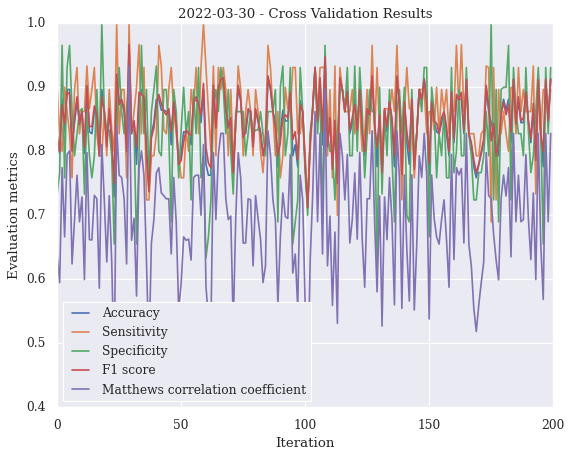

In [45]:
from matplotlib import pyplot as pyplot

def plot_cross_validation(results, name, save_dir):
    set_visual_styles()

    # plot all metrics
    epochs = len(results['fit_time'])
    x_axis = range(0, epochs)
    fig, ax = pyplot.subplots()
    ax.plot(x_axis, results['test_acc'], label='Accuracy')
    ax.plot(x_axis, results['test_sen'], label='Sensitivity')
    ax.plot(x_axis, results['test_spe'], label='Specificity')
    ax.plot(x_axis, results['test_f1'], label='F1 score')
    ax.plot(x_axis, results['test_mcc'], label='Matthews correlation coefficient')
    ax.legend(loc='best')
    pyplot.xlabel('Iteration')
    pyplot.ylabel('Evaluation metrics')
    pyplot.title(f'{name} - Cross Validation Results')
    pyplot.savefig(f'{save_dir}/cross_validation_results.png', dpi=300)
    pyplot.show()

# prepare folder
results_dir = os.path.join(model_dir, "results")
if not os.path.exists(results_dir):
  os.mkdir(results_dir)

# Plot the metrics and save the plot
plot_cross_validation(cv_results, model_name, results_dir)

## Final training of model

Train the model

In [51]:
# Use train and test data
eval_set = [(x_train, y_train), (x_test, y_test)]

# Define evaluation metrics
eval_metrics=["error", "logloss", "auc"]

# Fit the model
model.fit(x_train, y_train, # train just on training data 
          early_stopping_rounds=10, # to avoid over-fitting the model, stop if the results are not improving in 10 rounds
          eval_metric=eval_metrics, # use the metrics defined above
          eval_set=eval_set, # use train and test data to display the difference on train and test
          verbose=False # I don't want to print raw results, I will plot them later on instead
          )

XGBClassifier(colsample_bylevel=0.7, colsample_bytree=0.6, learning_rate=0.01,
              max_depth=15, min_child_weight=1.0)

Save it on disk (optional)

In [55]:
model_save_dir = os.path.join(model_dir, "model")
if not os.path.exists(model_save_dir):
  os.mkdir(model_save_dir)

model_save_path = os.path.join(model_save_dir, "model.pkl")
save_obj(model, model_save_path)

Plot feature importances

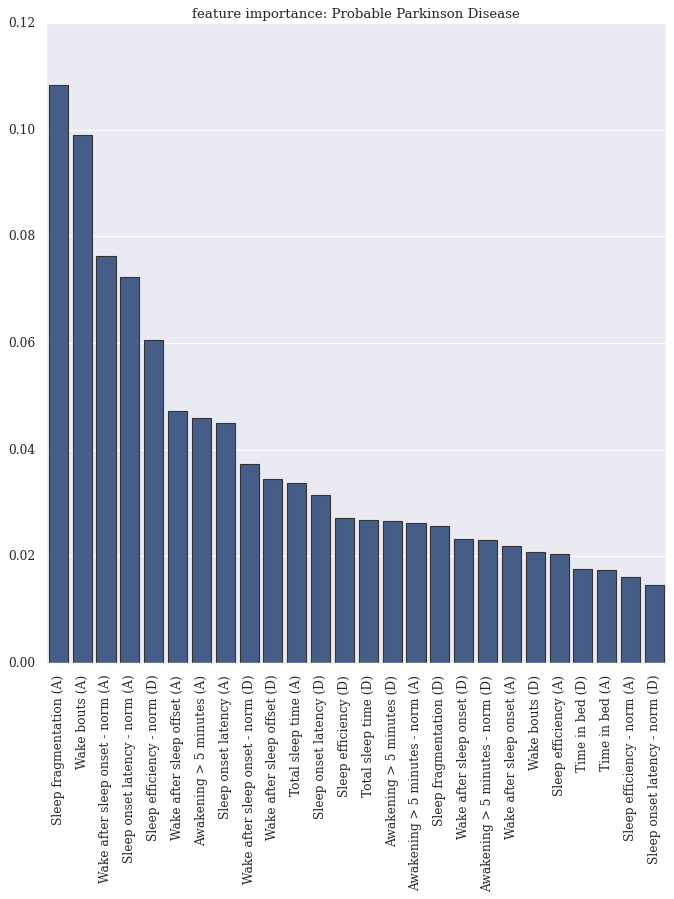

In [60]:
def plot_fi(model, f, y, k=10, sort=False, ax=None, fig_show=True, save_dir=results_dir):
    set_visual_styles()

    # Prepare the figure settings
    fig_kwargs = {
        "fig_size": (10, 10),
        "show_ticks": True,
        "ticks_rotation": 90,
        "x_label": "",
        "y_label": "",
        "title": f"feature importance: {y}"
    }

    # Prepare the bar-graph settings
    bar_kwargs = {"color": "#3b5b92", "edgecolor": "0.2"}

    # Get the feature importance(s)
    features = list(zip(model.feature_importances_, f))
    features = sorted(features, reverse=True) if sort else features

    if save_dir:
        # Get all features and store them
        all_features = [{"feature": feature, "importance": importance} for importance, feature in features]
        df_all_feat = pd.DataFrame(all_features)
        df_all_feat.to_excel(f'{save_dir}/features.xlsx', index=False)

    # Select limited features to plot
    features = features[:k if k < len(features) else len(features)] if k else features
    features = [{"feature": feature, "importance": importance} for importance, feature in features]

    # Create temporary DataFrame
    df_temp = pd.DataFrame(features)

    # Create figure if axes not inserted
    if not ax:
        fig, ax = plt.subplots(1, 1, figsize=fig_kwargs.get("fig_size"), sharex=False)

    # Create the barplot
    h = sns.barplot(x="feature", y="importance", data=df_temp, ax=ax, **bar_kwargs)

    # Set up the final adjustments
    h.set(xlabel=fig_kwargs.get("x_label"))
    h.set(ylabel=fig_kwargs.get("y_label"))
    h.set(title=fig_kwargs.get("title"))

    if fig_kwargs.get("show_ticks"):
        h.set_xticklabels(ax.get_xticklabels(), rotation=fig_kwargs.get("ticks_rotation"))
    else:
        h.set_xticklabels("")

        # Save the graph
    if save_dir:
        plt.savefig(f'{save_dir}/features.png', bbox_inches="tight")

    # Show the graph
    if fig_show:
        plt.show()
    else:
        plt.close()

plot_fi(model, 
        names, # names of features defined at the start of notebook
        'Probable Parkinson Disease', # description of plot,
        k=len(names), # lets print all features,
        sort=True, # lets sort the features by importance
        )

Plot evaluation metrics

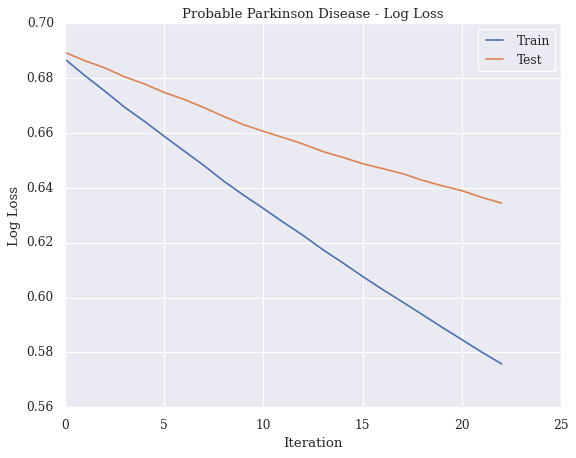

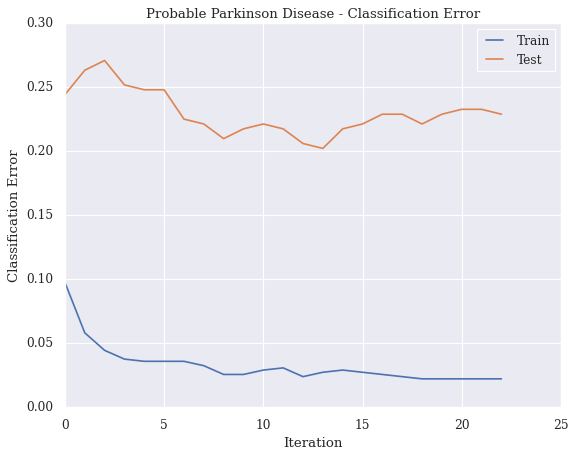

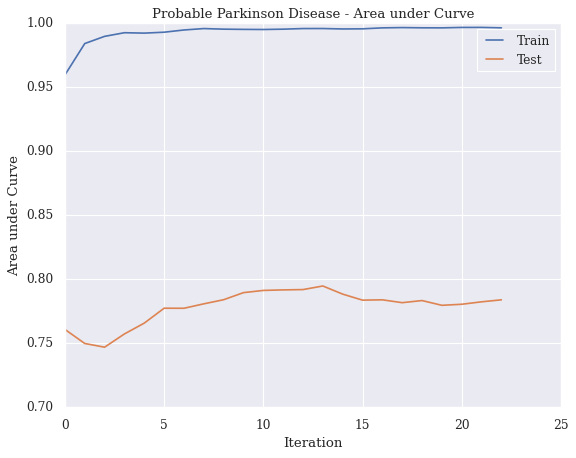

In [61]:
def plot_eval_metrics(model, name, save_dir=results_dir):
    set_visual_styles()

    # retrieve performance metrics
    results = model.evals_result()
    epochs = len(results['validation_0']['error'])
    x_axis = range(0, epochs)

    # plot log loss
    fig, ax = pyplot.subplots()
    ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
    ax.plot(x_axis, results['validation_1']['logloss'], label='Test')
    ax.legend()
    pyplot.xlabel('Iteration')
    pyplot.ylabel('Log Loss')
    pyplot.title(f'{name} - Log Loss')
    pyplot.savefig(f'{save_dir}/logloss.png', dpi=300)
    pyplot.show()

    # plot classification error
    fig, ax = pyplot.subplots()
    ax.plot(x_axis, results['validation_0']['error'], label='Train')
    ax.plot(x_axis, results['validation_1']['error'], label='Test')
    ax.legend()
    pyplot.xlabel('Iteration')
    pyplot.ylabel('Classification Error')
    pyplot.title(f'{name} - Classification Error')
    pyplot.savefig(f'{save_dir}/error.png', dpi=300)
    pyplot.show()

    
    # plot auc
    fig, ax = pyplot.subplots()
    ax.plot(x_axis, results['validation_0']['auc'], label='Train')
    ax.plot(x_axis, results['validation_1']['auc'], label='Test')
    ax.legend()
    pyplot.xlabel('Iteration')
    pyplot.ylabel('Area under Curve')
    pyplot.title(f'{name} - Area under Curve')
    pyplot.savefig(f'{save_dir}/auc.png', dpi=300)
    pyplot.show()

plot_eval_metrics(model, 'Probable Parkinson Disease')


Final results of the model on test data

In [63]:
from sklearn.metrics import recall_score, confusion_matrix, accuracy_score, matthews_corrcoef, f1_score

def sensitivity_score(y_true, y_pred):
    return recall_score(y_true, y_pred)

def specificity_score(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return tn / (tn + fp)

def results_to_print(y_test, predict):
    acc = f"{accuracy_score(y_test, predict):.2f}"
    sen = f"{sensitivity_score(y_test, predict):.2f}"
    spe = f"{specificity_score(y_test, predict):.2f}"
    f1 = f"{f1_score(y_test, predict):.2f}"
    mcc = f"{matthews_corrcoef(y_test, predict):.2f}"
    return f" ACC = {acc} | SEN = {sen} | SPE = {spe} | F1 = {f1} | MCC = {mcc}\n"

predict = model.predict(x_test)
print('After training results on test data: ')
print(results_to_print(y_test, predict))

# save results in results.txt
results_path = os.path.join(results_dir, "results.txt")
with open(results_path, "a") as text_file:
  text_file.write('After training results on test data: \n')
  text_file.write(results_to_print(y_test, predict))

print('Confusion matrix: ')
print(confusion_matrix(y_test, predict))

After training results on test data: 
 ACC = 0.80 | SEN = 0.57 | SPE = 0.87 | F1 = 0.56 | MCC = 0.43

Confusion matrix: 
[[175  27]
 [ 26  34]]


Final results on whole dataset (train & test data)

In [65]:
predict = model.predict(x)
print('After training results on whole dataset: ')
print(results_to_print(y, predict))

# save results in results.txt
results_path = os.path.join(results_dir, "results.txt")
with open(results_path, "a") as text_file:
  text_file.write('After training results on whole dataset: \n')
  text_file.write(results_to_print(y, predict))

print('Confusion matrix: ')
print(confusion_matrix(y, predict))

After training results on whole dataset: 
 ACC = 0.89 | SEN = 0.78 | SPE = 0.93 | F1 = 0.78 | MCC = 0.71

Confusion matrix: 
[[461  33]
 [ 36 124]]
